Compile mod files

import neuroML and SBML file. convert SBML to mod and clean up

Import libraries

In [1]:
from __future__ import print_function, division
import sys
import json
import numpy as np
from neuron import h
from math import exp
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt

define default default values for input files:

TODO: these should preferably be added by the user/added here directly

In [2]:
mod        = "./mod/"
defparams  = "./params-msn.json"
morphology = "./morphology/"

h.nrn_load_dll(mod + 'x86_64/.libs/libnrnmech.so')
h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')

1.0

def functions

In [3]:
def calculate_distribution(a1, a2, a3, a4, a5, a6, a7):
    # a1 is the distribution type:
    #     0 linear, 1 sigmoid, 2 exponential
    #     3 step for absolute distance (in microns)
    if a1 == 0: value = a3 + a2*a4
    if a1 == 1: value = a3 + (a4/(1+exp((a2-a5)/a6)))
    if a1 == 2: value = a3 + a6*exp(a4*(a2-a5))
    if a1 == 3:
        if (a2 > a5) and (a2 < a6):
            value = a3
        else:
            value = a4
    value = value*a7
    return value

In [4]:
def alpha(tstart, gmax, tau):
    # calc and returns a "magnitude" using an alpha function
    
    v = 1 - (h.t - tstart) / tau
    e = exp(v)
    mag = gmax * (h.t - tstart) / tau * e
    
    return mag

In [5]:
def save_vector(t, v, outfile):
    
    with open(outfile, "w") as out:
        for time, y in zip(t, v):
            out.write("%g %g\n" % (time, y))

In [6]:
class MSN:
    def __init__(self, params=defparams):
        Import = h.Import3d_SWC_read()
        Import.input(morphology + 'WT-P270-09-10ak.swc')
        imprt = h.Import3d_GUI(Import, 0)
        imprt.instantiate(None)
        h.define_shape()
        # h.cao0_ca_ion = 2  # default in nrn
        h.celsius = 35
        self._create_sectionlists()
        self._set_nsegs()
        self.v_init = -80
        for sec in self.allseclist:
            sec.Ra = 400
            sec.cm = 1
            sec.insert('pas')
            #sec.g_pas = 1e-5
            sec.e_pas = -70 # -73
        for sec in self.somalist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('can')
            sec.kb_cadyn = 200.
        for sec in self.axonlist:
            sec.insert('naf')
            #sec.insert('kaf')
            sec.insert('kas')
            #sec.insert('kdr')
            #sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
        for sec in self.dendlist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('cav32')
            sec.insert('cav33')

        with open(params) as file:
            par = json.load(file)

        self.distribute_channels("soma", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("axon", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("dend", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))

        self.distribute_channels("soma", "gbar_naf", 0, 1, 0, 0, 0, float(par['gbar_naf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kaf", 0, 1, 0, 0, 0, float(par['gbar_kaf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kas", 0, 1, 0, 0, 0, float(par['gbar_kas_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kdr", 0, 1, 0, 0, 0, float(par['gbar_kdr_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kir", 0, 1, 0, 0, 0, float(par['gbar_kir_somatic']['Value']))
        self.distribute_channels("soma", "gbar_sk", 0, 1, 0, 0, 0, float(par['gbar_sk_somatic']['Value']))
        self.distribute_channels("soma", "gbar_bk", 0, 1, 0, 0, 0, float(par['gbar_bk_somatic']['Value']))

        self.distribute_channels("axon", "gbar_naf", 0, 1, 0, 0, 0, float(par['gbar_naf_axonal']['Value']))
        self.distribute_channels("axon", "gbar_kas", 0, 1, 0, 0, 0, float(par['gbar_kas_axonal']['Value']))

        self.distribute_channels("dend", "gbar_naf", 2, 0.0, -0.02, 0.0, 1, float(par['gbar_naf_basal']['Value']))
        self.distribute_channels("dend", "gbar_kaf", 0, 1, 0, 0, 0, float(par['gbar_kaf_basal']['Value']))
        self.distribute_channels("dend", "gbar_kas", 0, 1, 0, 0, 0, float(par['gbar_kas_basal']['Value']))
        self.distribute_channels("dend", "gbar_kdr", 0, 1, 0, 0, 0, float(par['gbar_kdr_basal']['Value']))
        self.distribute_channels("dend", "gbar_kir", 0, 1, 0, 0, 0, float(par['gbar_kir_basal']['Value']))
        self.distribute_channels("dend", "gbar_sk", 0, 1, 0, 0, 0, float(par['gbar_sk_basal']['Value']))
        self.distribute_channels("dend", "gbar_bk", 0, 1, 0, 0, 0, float(par['gbar_bk_basal']['Value']))

        self.distribute_channels("soma", "pbar_cal12", 0, 1, 0, 0, 0, 0.8e-7)
        self.distribute_channels("soma", "pbar_cal13", 0, 1, 0, 0, 0, 0.1e-7)
        self.distribute_channels("soma", "pbar_car", 0, 1, 0, 0, 0, 8e-7)
        self.distribute_channels("soma", "pbar_can", 0, 1, 0, 0, 0, 12e-7)
        self.distribute_channels("soma", "kb_cadyn", 0, 1, 0, 0, 0, 200.0)
        self.distribute_channels("dend", "pbar_cal12", 0, 1, 0, 0, 0, 0.8e-7)
        self.distribute_channels("dend", "pbar_cal13", 0, 1, 0, 0, 0, 0.1e-7)
        self.distribute_channels("dend", "pbar_car", 0, 1, 0, 0, 0, 10e-7)
        self.distribute_channels("dend", "pbar_cav32", 0, 1, 0, 0, 0, 0.2e-8)
        self.distribute_channels("dend", "pbar_cav33", 0, 1, 0, 0, 0, 0.2e-8)

    def _create_sectionlists(self):
        self.allsecnames = []
        self.allseclist = h.SectionList()
        for sec in h.allsec():
            self.allsecnames.append(sec.name())
            self.allseclist.append(sec=sec)
        self.nsomasec = 0
        self.somalist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('soma') >= 0:
                self.somalist.append(sec=sec)
                if self.nsomasec == 0:
                    self.soma = sec
                self.nsomasec += 1
        self.axonlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('axon') >= 0:
                self.axonlist.append(sec=sec)
        self.dendlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('dend') >= 0:
                self.dendlist.append(sec=sec)

    def _set_nsegs(self):
        for sec in self.allseclist:
            sec.nseg = 2*int(sec.L/40.0)+1
        for sec in self.axonlist:
            sec.nseg = 2  # two segments in axon initial segment

    def _max_dist(self, axon_excluding=True):
        h.distance(sec=self.soma)
        dmax = 0
        for sec in self.allseclist:
            if axon_excluding and sec.name().find('axon') == 0: continue
            dmax = max(dmax, h.distance(1, sec=sec))
        return dmax

    def distribute_channels(self, as1, as2, a3, a4, a5, a6, a7, a8):
        h.distance(sec=self.soma)
        dmax = self._max_dist()
        for sec in self.allseclist:
            if sec.name().find(as1) >= 0:
                for seg in sec:
                    dist = h.distance(seg.x, sec=sec)
                    val = calculate_distribution(a3, dist, a4, a5, a6, a7, a8)
                    cmd = 'seg.%s = %g' % (as2, val)
                    exec(cmd)

In [7]:
def main(plotting=False, par="./params-msn.json", amp=0.265, modulation=1, additional=None): 
    
    # initiate cel
    cell = MSN(params=par)

    # set cascade ---- move to MSN def?
    casc = h.D1_Neuron_Model_0(0.5, sec=cell.soma)

    # set current injection
    stim = h.IClamp(0.5, sec=cell.soma)
        
    stim.amp = amp  # eg params-msn.json -stim 0.280
    stim.delay = 500
    stim.dur = 8000    
    
    # record vectors
    tm = h.Vector()
    tm.record(h._ref_t)
    vm = h.Vector()
    vm.record(cell.soma(0.5)._ref_v)
    da = h.Vector()
    da.record(casc._ref_DA)
    pka = h.Vector()
    pka.record(casc._ref_PKAc)
    ach = h.Vector()
    ach.record(casc._ref_ACh)
    
    # peak n dipp parameters
    da_peak   = 1500   # concentration [nM]
    da_tstart = 1500   # simulation time [ms]
    da_tau    = 500    # time constant [ms]
    
    ach_base   = 100    # concentration [nM]
    ach_tstart = 1500   # ms
    ach_tau    = 500    # ms
    
    tstop = 9000               # [ms]
    
    
    # check for alternative (argument) settings
    if additional:
        locals().update(additional)
        print(locals())
        
    # set pointers
    for sec in h.allsec():
        
        for seg in sec:
        
            h.setpointer(casc._ref_PKAc, 'pka', seg.kas )
            h.setpointer(casc._ref_PKAc, 'pka', seg.naf )

            try:
                
                h.setpointer(casc._ref_PKAc, 'pka', seg.kaf )
                            
            except NameError:
                
                continue
                
    # use variable time step?           
    cvode = h.CVode()
    #cvode.active(1)
    
    
    
    # initialize and set simulation length
    h.finitialize(cell.v_init)
    
    
        
    # run simulation
    while h.t < tstop:
    
        if modulation == 1:
        
            if h.t > min(da_tstart, ach_tstart): 
                
                # set DA and ACh values (using alpha function)
                casc.DA = alpha(da_tstart, da_peak, da_tau) 
                casc.ACh = ach_base - alpha(ach_tstart, ach_base, ach_tau)
                
        h.fadvance()
    
    results = {'tm': tm, 'vm':vm}
       
    if modulation == 1:
        
        results['da']  = da
        results['ach'] = ach
        results['pka'] = pka
        
        save_vector(tm, da, './da.out')
        save_vector(tm, ach, './ach.out')
        save_vector(tm, pka, './pka.out')
        
        save_vector(tm, vm, './vm_modulated.out')
        
        # plotting
        if plotting:
            try:
                import matplotlib.pyplot as plt
                
                # fig 1
                plt.plot(tm, vm)         
                #plt.plot(tm, kafgk)    
                plt.ylim([-100, 50])
                plt.legend(['vm', 'gk-kaf'])
                plt.savefig('vm_pka_gkaf_iksoma.png')
                
                # fig 2
                plt.figure()
                plt.plot(tm, da)
                plt.plot(tm, ach)
                plt.plot(tm, pka) 
                plt.legend(['da', 'ach', 'pka'])
                plt.savefig('peak_n_dipp.png')
                
                plt.show()
                
            except ImportError:
                print('no matplotlib available')
                
    else:
        save_vector(tm, vm, './vm_control.out') 
    
    return results

TODO: 
fix so that second simulation can be run
run in parallel?

In [8]:
res1 = main()
res2 = main(modulation=0)

In [9]:
plt.plot(res1['tm'], res1['da'],  'g')
plt.plot(res1['tm'], res1['pka'], 'r')
plt.plot(res1['tm'], res1['ach'], 'b')

In [10]:
plt.figure()
plt.plot(res1['tm'], res1['vm'],  'g', label='modulated')
plt.plot(res2['tm'], res2['vm'],  'b', label='control')
plt.legend(loc='best')

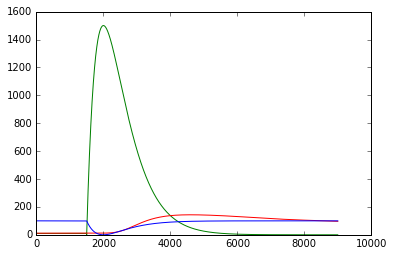

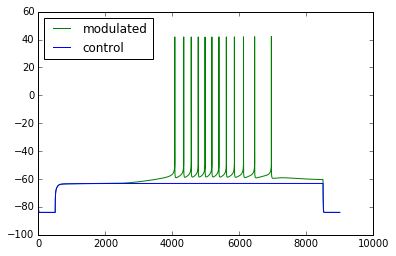

In [11]:
plt.show()